<a href="https://colab.research.google.com/github/lpam-sd/AAI-530_Grp_5/blob/main/Tommy_Github_Copy_of_Nurse_Stress_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stress Prediction for Nurses
## AAI 530 Group 5
### Deepti Pamula, Prema Mallikarjunan, Tommy Poole

This project uses machine learning and deep learning techniques to analyze the data found at https://www.kaggle.com/datasets/priyankraval/nurse-stress-prediction-wearable-sensors?resource=download gathered from nurses during the COVID-19 pandemic in a hospital settings, capturing real-world stress factors in a healthcare environment.

In [3]:
# Import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import keras
import tensorflow as tf

from tqdm.keras import TqdmCallback

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, make_scorer, precision_score, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GroupShuffleSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Input, BatchNormalization
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [4]:
# Set seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

In [5]:
# Connect data from colab
# Mount google drive to access data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
# Access csv data file from mounted google drive
csv_path = '/content/drive/MyDrive/AAI-530-IoT-Group5/Colab/merged_data.csv'

# Create a dataframe of the csv data
df2 = pd.read_csv(csv_path)

<ipython-input-6-d076502aae57>:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(csv_path)


In [7]:
# Convert problematic columns to a specific data type
df2["id"] = df2["id"].astype(str)  # Convert to string
df2["label"] = df2["label"].astype("int32")

In [ ]:
"""
# Use for local machine data import
# Import the data
df2 = pd.read_csv("merged_data.csv", low_memory=False, parse_dates=['datetime'])

# Convert problematic columns to a specific data type
df2["id"] = df2["id"].astype(str)  # Convert to string
df2["label"] = df2["label"].astype("int32")

## Dataset Nine Columns Description
### (From Kaggle Project Description)

**X, Y, Z:**
Description: Numerical values representing orientation data.
Unique Entries: Each column has 256 unique values.

**EDA (Electrodermal Activity):**
Description: Continuous numerical values measuring electrodermal activity.
Unique Entries: Contains 274,452 unique numerical values.

**HR (Heart Rate):**
Description: Continuous numerical values representing heart rate measurements.
Unique Entries: Comprises 6,268 distinct numerical values.

**TEMP (Temperature):**
Description: Continuous numerical values denoting temperature readings.
Unique Entries: Contains 599 unique numerical values.

**id:**
Description: Categorical data serving as identifiers for specific subjects or entities.
Unique Entries: Consists of 18 distinct categorical entries.

**datetime:**
Description: Object type encompassing a wide range of date and time entries.
Unique Entries: Holds approximately 10.6 million unique date and time values.

**label:**
Description: Categorical data representing different states or classes.

Unique Entries: Contains three unique categorical values.
Each column in this dataset offers distinct information. The orientation data (X, Y, Z) seemingly represents spatial or directional measurements. Electrodermal activity (EDA), heart rate (HR), and temperature (TEMP) columns provide continuous physiological measurements. The 'id' column serves as a categorical identifier, while 'datetime' indicates timestamps. Lastly, the 'label' column presents categorical classifications.

# Exploratory Data Analysis

In [6]:
df2.describe()

,X,Y,Z,EDA,HR,TEMP,label
count,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07
mean,-2.823775e+01,-9.091032e-01,2.382449e+01,3.502127e+00,8.576090e+01,3.223435e+01,1.554202e+00
std,3.142310e+01,3.343382e+01,2.985317e+01,5.656541e+00,1.419642e+01,2.260516e+00,7.891827e-01
min,-1.280000e+02,-1.280000e+02,-1.280000e+02,0.000000e+00,5.100000e+01,2.409000e+01,0.000000e+00
25%,-5.200000e+01,-1.900000e+01,4.000000e+00,2.242060e-01,7.672000e+01,3.019000e+01,1.000000e+00
50%,-3.300000e+01,1.000000e+00,2.500000e+01,1.157407e+00,8.390000e+01,3.257000e+01,2.000000e+00
75%,-1.400000e+01,1.700000e+01,4.900000e+01,4.077436e+00,9.310000e+01,3.425000e+01,2.000000e+00
max,1.270000e+02,1.270000e+02,1.270000e+02,5.976071e+01,1.802300e+02,3.659000e+01,2.000000e+00


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509051 entries, 0 to 11509050
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   X         float64
 1   Y         float64
 2   Z         float64
 3   EDA       float64
 4   HR        float64
 5   TEMP      float64
 6   id        object 
 7   datetime  object 
 8   label     int32  
dtypes: float64(6), int32(1), object(2)
memory usage: 746.4+ MB


In [8]:
# Review the end of the dataframe
df2.tail(10)

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
11509041,-32.0,-43.0,56.0,3.398877,88.37,33.77,F5,2020-07-23 17:28:59.718749952,2
11509042,-16.0,-52.0,52.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.750000128,2
11509043,-47.0,-78.0,5.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.781250048,2
11509044,-45.0,-77.0,-24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.812499968,2
11509045,-51.0,-77.0,23.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.843749888,2
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2
11509050,-22.0,-24.0,29.0,3.374543,88.33,33.75,F5,2020-07-23 17:29:00.000000000,2


In [9]:
# Check for missing data
df2.isna().sum()

,0
X,0
Y,0
Z,0
EDA,0
HR,0
TEMP,0
id,0
datetime,0
label,0


In [10]:
df2.duplicated().sum()

105606

In [11]:
df2.drop_duplicates(inplace=True)

In [12]:
df2.drop('datetime', axis=1).corr(numeric_only=True)

,X,Y,Z,EDA,HR,TEMP,label
X,1.000000,0.061378,0.197679,0.096056,0.128854,0.026448,-0.009016
Y,0.061378,1.000000,0.019268,-0.094499,-0.066294,-0.079620,-0.024973
Z,0.197679,0.019268,1.000000,0.006093,-0.104408,-0.031794,-0.058929
EDA,0.096056,-0.094499,0.006093,1.000000,0.141676,0.352223,0.054456
HR,0.128854,-0.066294,-0.104408,0.141676,1.000000,0.156965,-0.030715
TEMP,0.026448,-0.079620,-0.031794,0.352223,0.156965,1.000000,0.138786
label,-0.009016,-0.024973,-0.058929,0.054456,-0.030715,0.138786,1.000000


Generating Histograms: 100%|██████████| 7/7 [07:44<00:00, 66.41s/it]


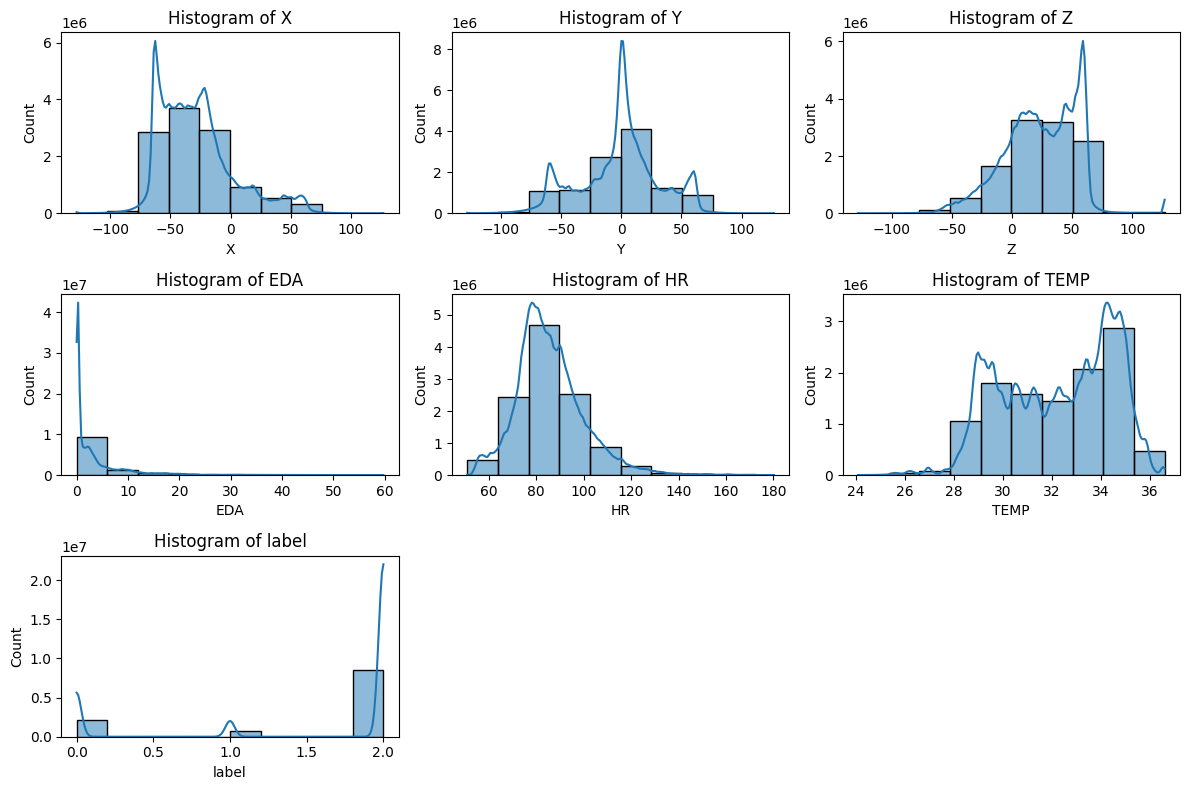

In [13]:
# Visualize the data as histograms
plt.figure(figsize=(12, 8))
columns = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'label']

# Use tqdm to wrap the loop for progress tracking
for i, col in enumerate(tqdm(columns, desc="Generating Histograms"), 1):
    plt.subplot(3, 3, i)
    sns.histplot(df2[col], kde=True, bins=10)
    plt.title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [14]:
# Ensure datetime is in datetime format
df2['datetime'] = pd.to_datetime(df2['datetime'])

In [16]:
# Set datetime as the index
df2.set_index('datetime', inplace=True)

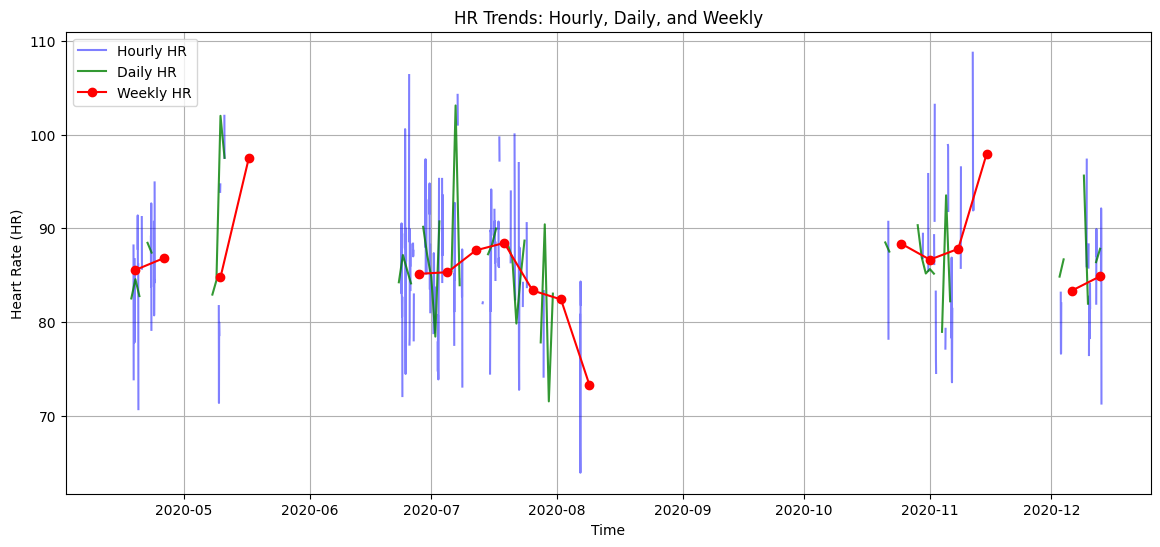

In [17]:
# Add hourly, daily, weekly attributes to capture trends for heartrate
hr_hourly = df2['HR'].resample('h').mean()
hr_daily = df2['HR'].resample('D').mean()
hr_weekly = df2['HR'].resample('W').mean()
data_hourly = df2[['X', 'Y', 'Z', 'EDA', 'HR']].resample('h').mean()

# Visualize the data to look for trends
plt.figure(figsize=(14, 6))

# Plot all hourly, daily and weekly trends
plt.plot(hr_hourly, linestyle='-', alpha=0.5, color='blue', label='Hourly HR')
plt.plot(hr_daily, linestyle='-', alpha=0.8, color='green', label='Daily HR')
plt.plot(hr_weekly, linestyle='-', alpha=1.0, color='red', marker='o', label='Weekly HR')
plt.xlabel("Time")
plt.ylabel("Heart Rate (HR)")
plt.title("HR Trends: Hourly, Daily, and Weekly")
plt.legend()
plt.grid(True)

plt.show()

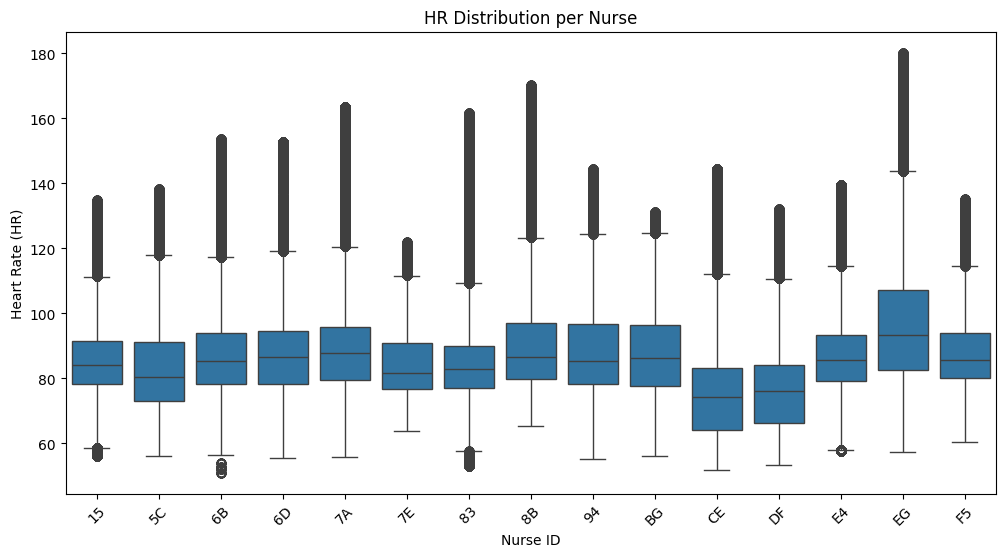

In [18]:
# Check heartrate for trends in boxplot format
plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='HR', data=df2)
plt.title('HR Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('Heart Rate (HR)')
plt.xticks(rotation=45)
plt.show()

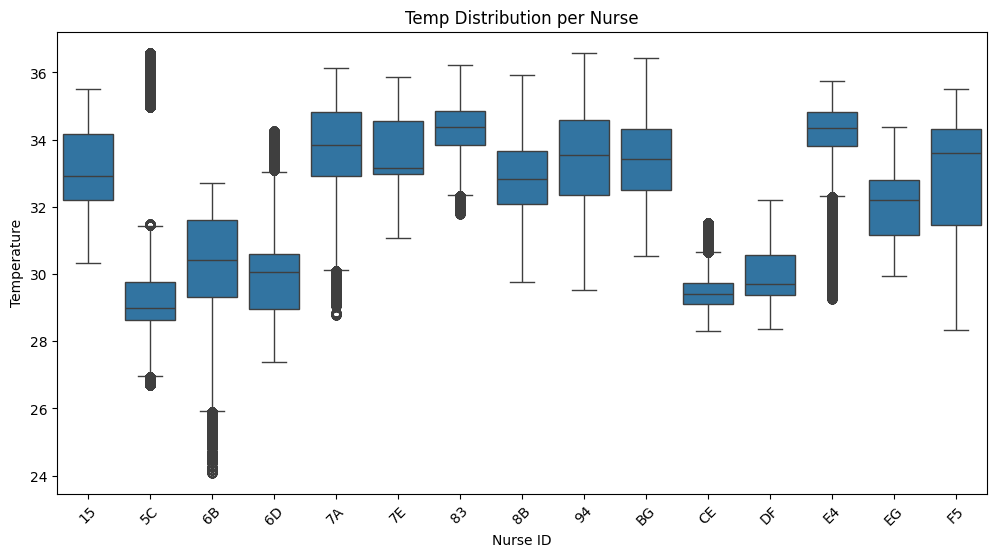

In [19]:
# Check the temperature field in boxplot format to check for trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='TEMP', data=df2)
plt.title('Temp Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.show()

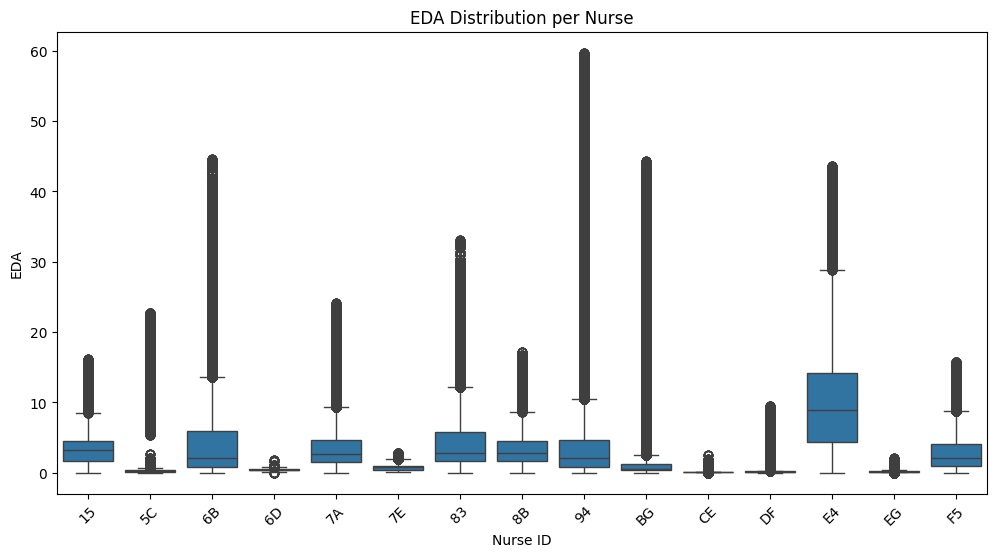

In [20]:
# Plot the EDA in boxplot to explore trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='id', y='EDA', data=df2)
plt.title('EDA Distribution per Nurse')
plt.xlabel('Nurse ID')
plt.ylabel('EDA')
plt.xticks(rotation=45)
plt.show()

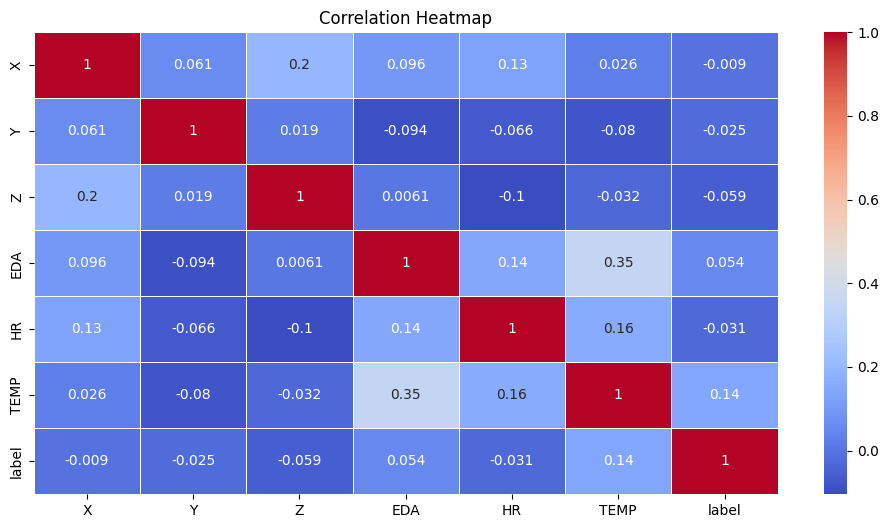

In [21]:
plt.figure(figsize=(12,6))
sns.heatmap(df2.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

#Run These

In [8]:
# Label Encoding for 'id' to ensure correct data type
le = LabelEncoder()
df2['id_encoded'] = le.fit_transform(df2['id'])

# One-Hot Encoding for 'label' to improve classification performance
ohe = OneHotEncoder(sparse_output=False)
label_encoded = ohe.fit_transform(df2[['label']])
label_columns = ohe.get_feature_names_out(['label'])
df2[label_columns] = label_encoded

In [9]:
# Reset the index
df2 = df2.reset_index()

# Models

## Random Forest Machine Learning Algorithm

Random Forrest Machine Learning Algorithm for stress classification based on other features.



In [10]:
# Convert datetime into more meaningful units for Random Forest Classifier
df2['time_of_day'] = df2['datetime'].dt.hour
df2['day_of_week'] = df2['datetime'].dt.dayofweek
df2['month'] = df2['datetime'].dt.month
df2['day_of_month'] = df2['datetime'].dt.day

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
features = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id_encoded', 'time_of_day','day_of_month', 'day_of_week', 'month']
X = df2[features]
y = df2['label'] # Using the columns of data above to predict stress in the label column

In [32]:
# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Define the number of trees, less for overfitting purposes
n_estimators = 3

# Initialize the Random Forest classifier with a custom iterator
rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42, verbose=0)

# Create a custom fit method with TQDM
def fit_with_progress(clf, X, y):
    for _ in tqdm(range(n_estimators), desc="Training Random Forest"):
        clf.fit(X, y)
    return clf

# Fit the model with progress bar
rf_classifier = fit_with_progress(rf_classifier, X_train, y_train)

Training Random Forest: 100%|██████████| 3/3 [06:03<00:00, 121.13s/it]


In [35]:
# Using our trained model, predict the results using our X_test data
y_pred = rf_classifier.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    432579
           1       1.00      1.00      1.00    154433
           2       1.00      1.00      1.00   1693677

    accuracy                           1.00   2280689
   macro avg       1.00      1.00      1.00   2280689
weighted avg       1.00      1.00      1.00   2280689


Confusion Matrix:
[[ 432519       1      59]
 [      2  154431       0]
 [     42       0 1693635]]


In [36]:
# Show the feature importance print out
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_classifier.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
         feature  importance
7    time_of_day    0.176057
8   day_of_month    0.163810
6     id_encoded    0.163626
3            EDA    0.148077
9    day_of_week    0.120013
5           TEMP    0.112667
10         month    0.069755
2              Z    0.014792
4             HR    0.014747
1              Y    0.009613
0              X    0.006843


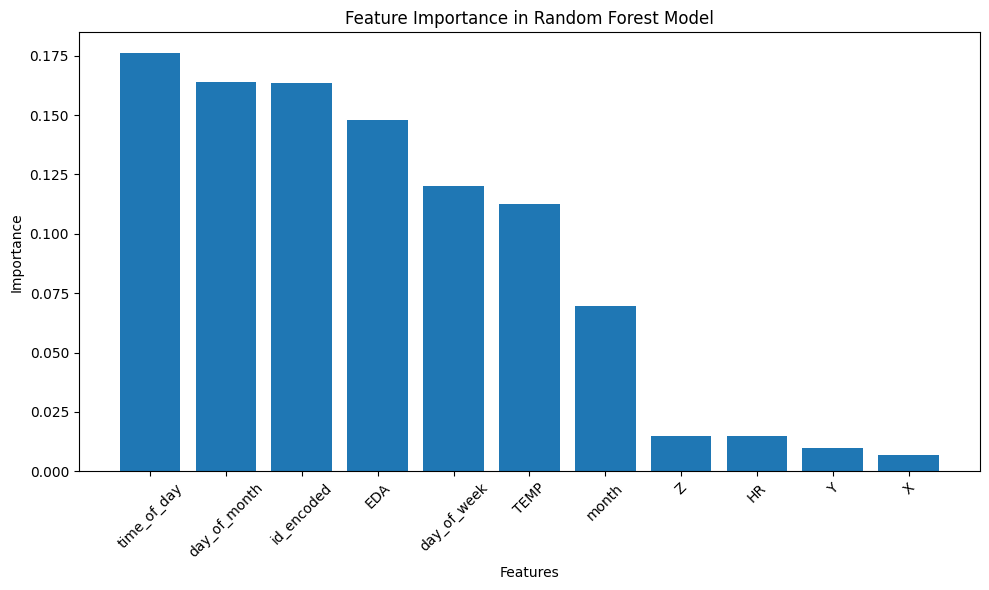

In [37]:
# Visualie feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Model 2a - Deep Learning Long Short Term Memory (LSTM) Model


Can we predict EDA using the other variables in the dataset?

In [11]:
# Create a copy of the data called d3
df3 = df2.copy()

In [12]:
# Orient data by time
df3 = df3.sort_values('datetime')

In [15]:
# Filter the data to only include june through august data
df_subset = df3[(df3['datetime'].dt.month >= 6) & (df3['datetime'].dt.month <= 8)]

In [16]:
# Ensure datetime is in pd.datetime
df3['datetime'] = pd.to_datetime(df3['datetime'])

In [17]:
# Print total number of rows in df_subset
print(f"Total number of rows in df_subset: {len(df_subset)}")

Total number of rows in df_subset: 7368560


In [18]:
# Define nurse id as id
nurse_ids = df_subset['id_encoded'].unique()

# Print row count for each nurse in subset dataframe
for nurse_id in nurse_ids:
    nurse_data = df_subset[df_subset['id_encoded'] == nurse_id]
    print(f"Nurse ID {nurse_id}: {len(nurse_data)} rows")

Nurse ID 4: 689971 rows
Nurse ID 2: 825549 rows
Nurse ID 1: 773768 rows
Nurse ID 8: 447853 rows
Nurse ID 12: 1187444 rows
Nurse ID 10: 675844 rows
Nurse ID 0: 309131 rows
Nurse ID 14: 535706 rows
Nurse ID 7: 423763 rows
Nurse ID 3: 591363 rows
Nurse ID 11: 908168 rows


In [19]:
#Take the first rows from each nurse to get a representative sample but a smaller set of overal data
df_subset = df_subset.groupby('id_encoded').head(10000)

In [20]:
df_subset['time_of_day'] = df_subset['datetime'].dt.hour * 60 + df_subset['datetime'].dt.minute
df_subset['day_of_week'] = df_subset['datetime'].dt.dayofweek
df_subset['day_of_month'] = df_subset['datetime'].dt.day

In [21]:
# Store datetime seperately
datetime_col = df_subset['datetime']

# Normalize the data using minmax scaler
scaler = MinMaxScaler()
df_subset[['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP','time_of_day','day_of_week','day_of_month',]] = scaler.fit_transform(df_subset[['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP','time_of_day','day_of_week','day_of_month']])

In [22]:
# Get unique nurse IDs
unique_nurse_ids = df_subset['id_encoded'].unique()

# Determine the number of nurses
num_nurses = len(unique_nurse_ids)

# Keep the last nurses for validation
val_nurse_ids = unique_nurse_ids[-3:]

# Create training and validation sets based on nurse IDs
train_df = df_subset[~df_subset['id_encoded'].isin(val_nurse_ids)]
val_df = df_subset[df_subset['id_encoded'].isin(val_nurse_ids)]

In [23]:
# Print the length of the train and val df
print(f"Length of train_df: {len(train_df)}")
print(f"Length of val_df: {len(val_df)}")

Length of train_df: 80000
Length of val_df: 30000


In [24]:
# Define features using almost all features plus additional based off datetime data
features = ['X', 'Y', 'Z', 'EDA', 'TEMP', 'label', 'id_encoded','time_of_day', 'day_of_week','day_of_month']
label_column =  'HR'

#
def create_sequences(group, sequence_length, ph):
    sequences = []
    labels = []
    for i in range(len(group) - sequence_length - ph + 1):
        seq = group[features].iloc[i:i+sequence_length].values
        label = group[label_column].iloc[i + sequence_length + ph - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Use smaller sequence lengths for RAM utilization, also larger sequences didn't seem to yield meaningful results
sequence_length = 25  # 25 time steps
ph = 5  # 5 time steps

X_sequences = []
y_sequences = []

for nurse_id in tqdm(train_df['id_encoded'].unique(), desc="Processing nurses"):
    nurse_data = train_df[train_df['id_encoded'] == nurse_id]
    X_seq, y_seq = create_sequences(nurse_data, sequence_length, ph)
    X_sequences.append(X_seq)
    y_sequences.append(y_seq)

# Combine all sequences
X_sequences = np.concatenate(X_sequences)
y_sequences = np.concatenate(y_sequences)

print(f"Total sequences: {len(X_sequences)}")
print(f"Shape of X_sequences: {X_sequences.shape}")
print(f"Shape of y_sequences: {y_sequences.shape}")

Processing nurses: 100%|██████████| 8/8 [01:28<00:00, 11.09s/it]

Total sequences: 79768
Shape of X_sequences: (79768, 25, 10)
Shape of y_sequences: (79768,)


In [25]:
# Adjust the X and y sequences into numpy arrays to ensure they're in the correct format for tensor flow
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [26]:
# Define input shape
input_shape = (sequence_length, len(features))

# Fit the model, using less complexity in the model to slow down training
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(16),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='linear')
])

# Define the optimizer, using slower learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='mse', optimizer=optimizer)

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 25, 32)              │           5,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 25, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,849 (34.57 KB)

 Trainable params: 8,753 (34.19 KB)

 Non-trainable params: 96 (384.00 B)

In [27]:
# Calculate the number of samples for validation
val_size = int(len(X_sequences) * 0.2)

# Split the data, keeping the last 20% for validation
X_train = X_sequences[:-val_size]
y_train = y_sequences[:-val_size]
X_val = X_sequences[-val_size:]
y_val = y_sequences[-val_size:]

# Define the number of epochs and batch size
epochs = 15
batch_size = 256

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ],
    verbose=1
)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - loss: 0.5917 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - loss: 0.1325 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - loss: 0.0516 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.0252 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0152 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - loss: 0.0114 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 0.0100 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - loss: 0.0093 - val_loss: 0.0125 - learning_rate: 0.0010
Epoch 9/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - loss: 0.0089 - val_loss: 0.0109 - learning_rate:

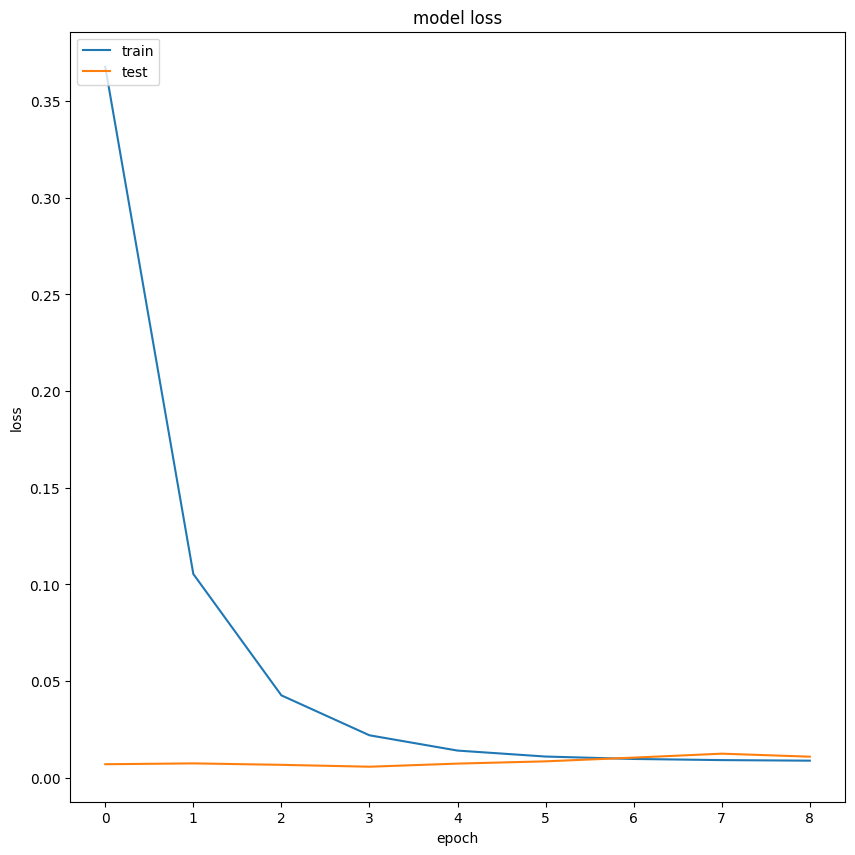

In [28]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

In [29]:
# Evaluate the model
loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")

499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0036
Validation Loss: 0.005717069376260042


499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


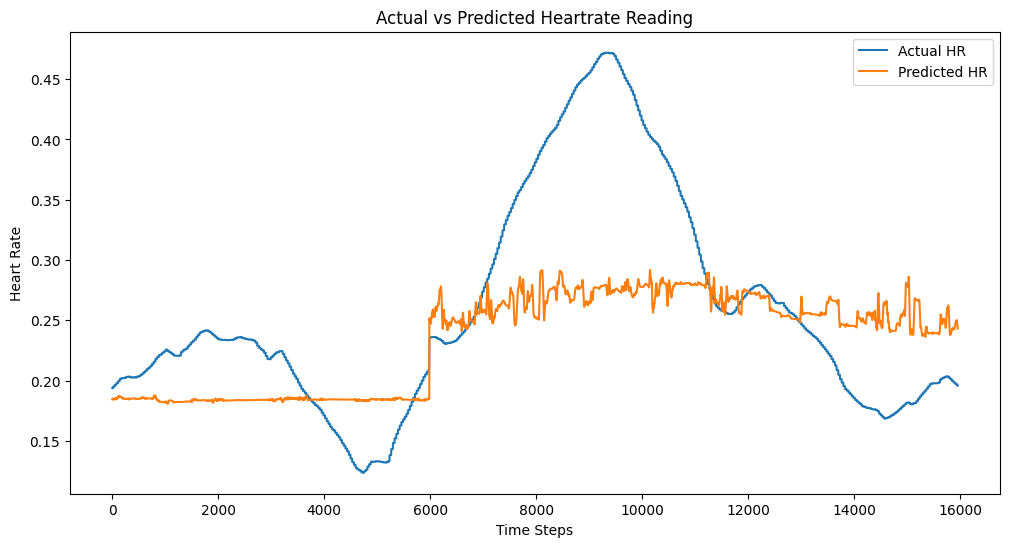

In [38]:
# Use X_val and y_val for prediction
predictions = model.predict(X_val)

# Use y_val and labels to chart actual versus predicted
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual HR')
plt.plot(predictions, label='Predicted HR')
plt.title('Actual vs Predicted Heartrate Reading')
plt.xlabel('Time Steps')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()

In [32]:
# Use the model to predict the heart rate on the val_df
predictions = model.predict(X_val)

499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


In [36]:
# Code thanks to marbut and univeristy of san diego AAI 530

val_arrays = []
val_labs = []

# Create sequences
for i in range(len(val_df) - sequence_length - ph):
    if i + sequence_length + ph < len(val_df):
        val_arrays.append(val_df[features].iloc[i:i+sequence_length].values)
        val_labs.append(val_df['HR'].iloc[i+sequence_length+ph-1])

# Use the pad_sequences function on input sequences
padded_sequences = pad_sequences(val_arrays,
                               maxlen=sequence_length,
                               padding='post',  # pad at start of sequence
                               truncating='post',  # truncate at end if needed
                               value=0.0)  # use 0.0 for padding value

# Convert datatype to np.float32
val_arrays = np.array(padded_sequences, dtype = object).astype(np.float32)

# Convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


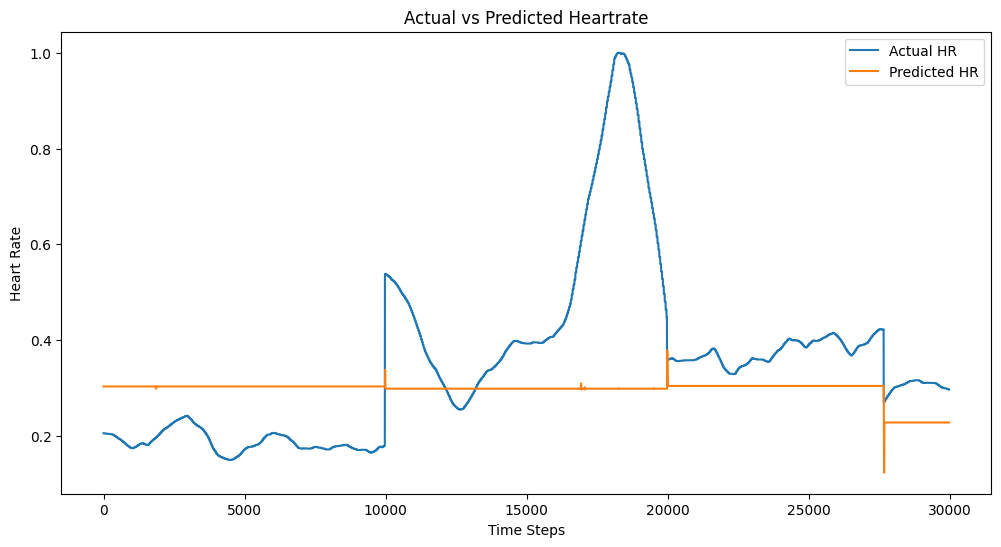

In [37]:
# Make predictions on the validation data that was not used in training
predictions = model.predict(val_arrays)

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(val_labs, label='Actual HR')
plt.plot(predictions, label='Predicted HR')
plt.title('Actual vs Predicted Heartrate')
plt.xlabel('Time Steps')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()

# LSTM Approach 2b

In [7]:
df_cleaned = df2.copy()
df_cleaned = df_cleaned.reset_index(drop=True)
subset_size= int(len(df_cleaned) * 0.001)

In [8]:
#take random data subset
df_subset = df_cleaned.iloc[:subset_size]

#split data subset 80/20 for train/validation
split_pos = int(len(df_subset) * 0.8)
train_df = df_subset.iloc[:split_pos]
val_df = df_subset.iloc[split_pos:]
#reset the indices
train_df = train_df.reset_index()
val_df = val_df.reset_index()
seq_arrays = []
seq_labs = []
from sklearn.preprocessing import StandardScaler

In [9]:
# Define sequence length and prediction horizon
seq_length = 60  # Use last time steps
ph = 15  # Predict 15 time steps

# Features to use for prediction
feat_cols = ['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP']

scaler = StandardScaler()
train_df[feat_cols] = scaler.fit_transform(train_df[feat_cols])  # Fit & transform on train data
val_df[feat_cols] = scaler.transform(val_df[feat_cols])


# Convert dataset into sequences
gap_values = train_df[feat_cols].values
seq_arrays, seq_labs = [], []

for i in range(len(gap_values) - seq_length - ph):
    seq = gap_values[i: i + seq_length]
    label = gap_values[i + seq_length + ph - 1][0]
    seq_arrays.append(seq)
    seq_labs.append(label)

# Convert lists to numpy arrays (ensure compatibility with TensorFlow)
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)

In [10]:
print(f"Sequence shape: {seq_arrays.shape}")  # Should be (num_samples, 60, num_features)
print(f"Labels shape: {seq_labs.shape}")  # Should be (num_samples,)

Sequence shape: (9132, 60, 6)
Labels shape: (9132,)


In [11]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [14]:
# define path to save model
model_path = 'LSTM_model1.keras'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_arrays.shape[1], nb_features),
         units=10,
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=5,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 10)              │             680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 5)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,006 (3.93 KB)

 Trainable params: 1,006 (3.93 KB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=20, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Epoch 1/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.2864 - mse: 0.2864 - val_loss: 0.0460 - val_mse: 0.0460
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.2914 - mse: 0.2914 - val_loss: 0.0547 - val_mse: 0.0547
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - loss: 0.2515 - mse: 0.2515 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.2738 - mse: 0.2738 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.2281 - mse: 0.2281 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.2190 - mse: 0.2190 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 7/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.2208 - mse: 0.2208 - val_loss: 0.0518 - val_mse: 0.0518
Epoch 8/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.2488 - mse: 0.2488 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 9/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 

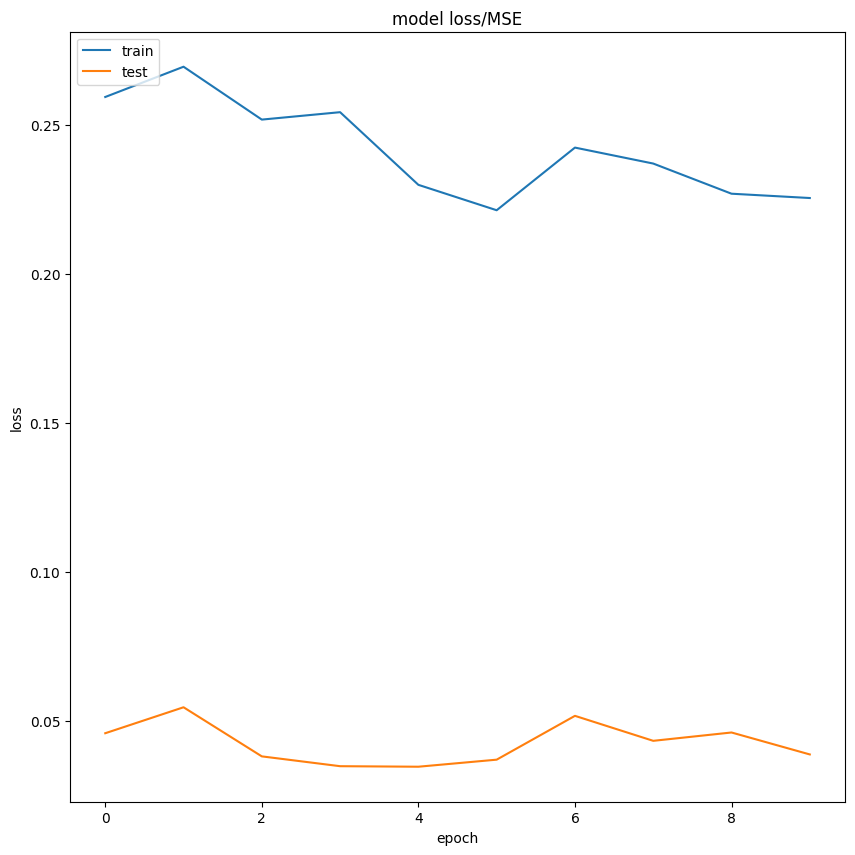

In [23]:
# Summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

In [25]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
seq_length = 30   # LSTM requires sequences of length 30
ph = 5            # Predictive horizon (how many steps ahead we want to predict)

 # Choosing all relevant features
feat_cols = ['X', 'Y', 'Z', 'HR', 'EDA', 'TEMP']


# Extract GAP values from your validation set
gap_values_val = val_df[feat_cols].values
labels_val = val_df['label'].values  # Keep labels separately

# Create sequences starting with seq length
for i in range(len(gap_values_val) - seq_length - ph):
    # Extract sequence of past `seq_length` feature readings
    gap_sequence = gap_values_val[i: i + seq_length]

    # Append sequence to val_arrays
    val_arrays.append(gap_sequence)

    # The label is at `seq_length + ph - 1`
    gap_label = labels_val[i + seq_length + ph - 1]
    val_labs.append(gap_label)

# Convert lists to NumPy arrays
val_arrays = np.array(val_arrays, dtype=np.float32)  # Shape: (samples, seq_length, num_features)
val_labs = np.array(val_labs, dtype=np.float32)  # Shape: (samples, )
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

71/71 - 0s - 7ms/step - loss: 8.1694 - mse: 8.1694

MSE: 8.169371604919434


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


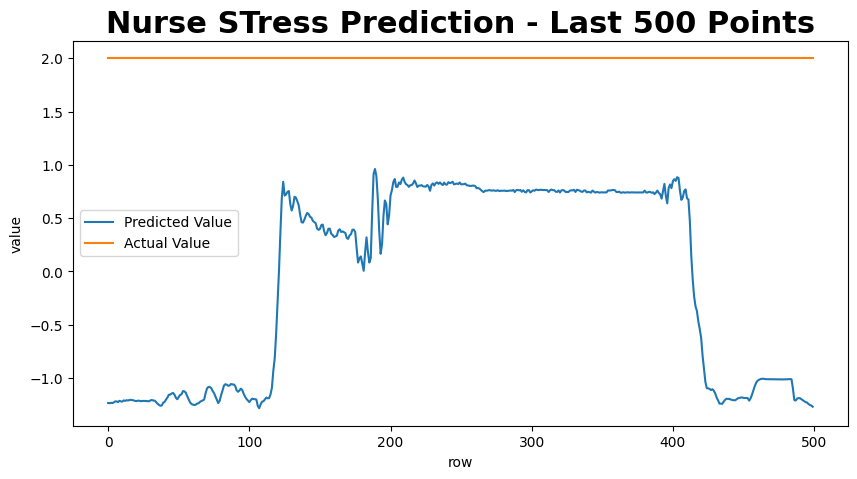

In [26]:
# Run the prediction on the validation data
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Nurse STress Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")